# Localized Potential Field Extrapolations

1. Download HMI LOS magnetogram
2. Download corresponding AIA 171 image
3. Crop both to FOV relevant to chosen AR
4. Reproject HMI using the planar screen approximation, putting the screen at the surface of the sun and setting the orientation of the screen using the center of the AR
5. Revive implementation of the Green's function potential field extrapolation
6. Use `streamtracer` to trace fieldlines in an HCC coordinate frame centered on the AR center (that also defined the planar screen orientation)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
from streamtracer import VectorGrid,StreamTracer
import xarray

import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, SphericalRepresentation
from astropy.visualization import ImageNormalize

import sunpy.map
#from sunpy.net import Fido, attrs as a
from sunpy.coordinates import PlanarScreen, Helioprojective, HeliographicStonyhurst

/Users/willbarnes/anaconda/envs/greensfield-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import greensfield

In [3]:
files = [
    '../data/aia.lev1.171A_2011_02_12T15_32_36.34Z.image_lev1.fits',
    '../data/hmi.m_45s.2011.02.12_15_33_45_TAI.magnetogram.fits',
]

In [4]:
m_aia, m_hmi = sunpy.map.Map(files)

In [5]:
m_aia_cutout = m_aia.submap(
    SkyCoord(Tx=-475*u.arcsec, Ty=-400*u.arcsec, frame=m_aia.coordinate_frame),
    top_right=SkyCoord(Tx=-125*u.arcsec, Ty=-50*u.arcsec, frame=m_aia.coordinate_frame),
)

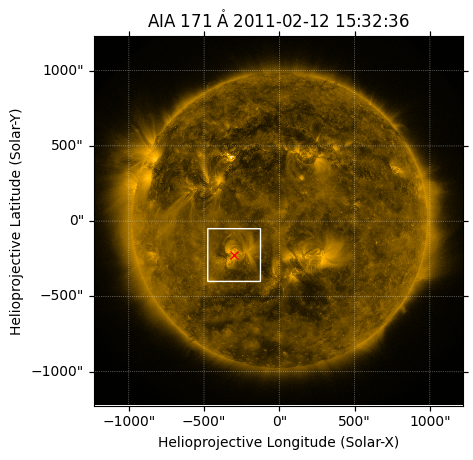

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia)
m_aia.plot(axes=ax)
m_aia_cutout.draw_extent(axes=ax)
ax.plot_coord(m_aia_cutout.center, marker='x', color='r')

In [7]:
ar_center = m_aia_cutout.center.transform_to(HeliographicStonyhurst)

In [8]:
extrapolator = greensfield.ObliqueSchmidtExtrapolator(
    m_hmi,
    ar_center,
    [m_aia_cutout.bottom_left_coord, m_aia_cutout.top_right_coord],
    resample_factor=0.1,
)

INFO: Apparent body location accounts for 492.53 seconds of light travel time [sunpy.coordinates.ephemeris]


In [9]:
print(extrapolator.scale)

[3.61840911 3.61448304 3.61448304] Mm


In [10]:
print(extrapolator.shape)

[82 74 82]


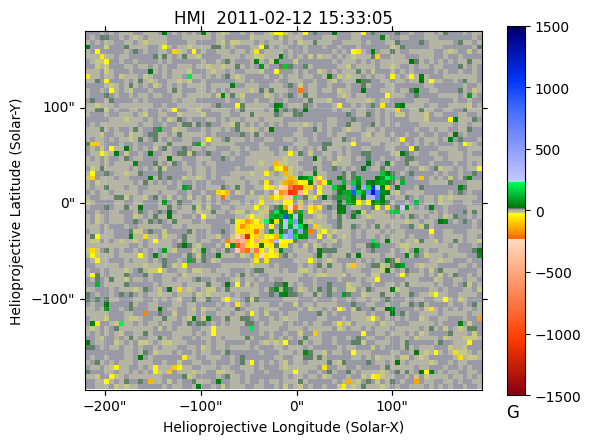

In [11]:
extrapolator.boundary_magnetogram.peek(norm=ImageNormalize(vmin=-1500, vmax=1500),cmap='hmimag')

(-50.0, 620.0)

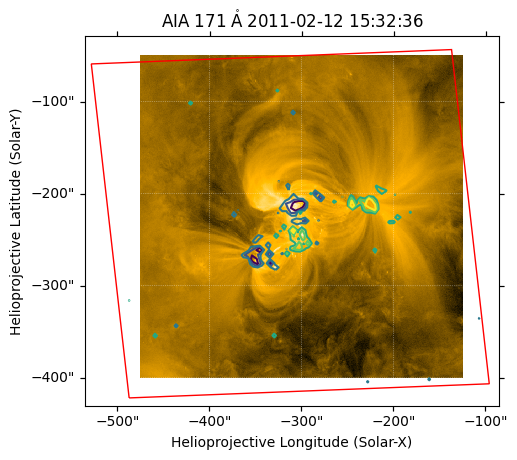

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax)
with PlanarScreen(ar_center, distance_from_center=ar_center.radius, ):
    extrapolator.boundary_magnetogram.draw_contours([-50,-25,-10,10,25,50]*u.percent,
                                                    axes=ax,
                                                    cmap='viridis')
    extrapolator.boundary_magnetogram.draw_extent(axes=ax, color='r',)
ax.set_xlim(-100,650)
ax.set_ylim(-50,620)

In [13]:
ds = extrapolator.extrapolate()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


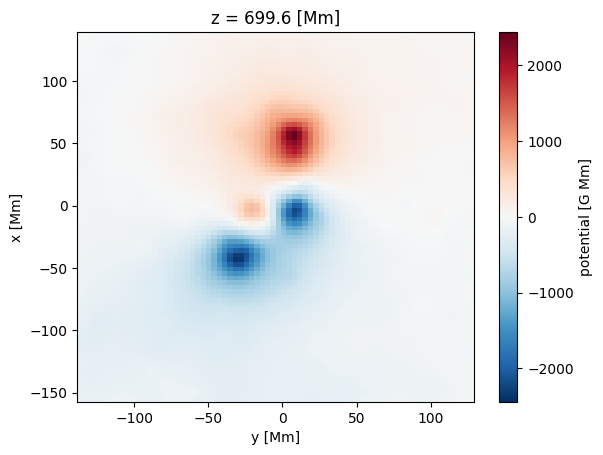

In [14]:
ds['potential'].sel(z=700, method='nearest').plot()

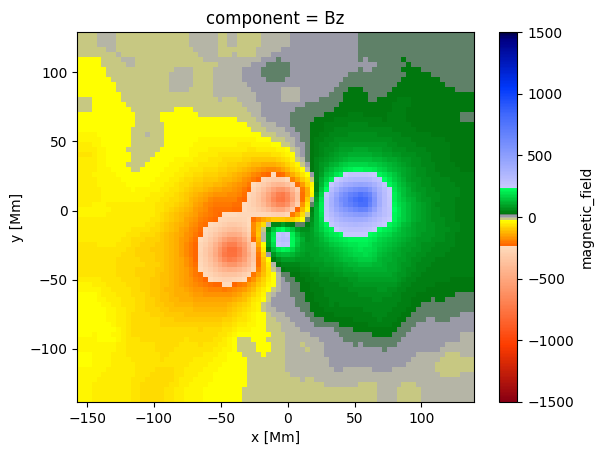

In [15]:
ds['magnetic_field'].sel(component='Bz').sum(dim='z').plot(
    x='x',
    y='y',
    norm=matplotlib.colors.Normalize(vmin=-1500,vmax=1500),
    cmap='hmimag'
)

In [56]:
import warnings
import yt
from sunpy.image.resample import resample


@u.quantity_input
def magnetic_field_to_yt_dataset(Bx: u.gauss,
                                 By: u.gauss,
                                 Bz: u.gauss,
                                 range_x: u.cm,
                                 range_y: u.cm,
                                 range_z: u.cm):
    """
    Reshape vector magnetic field data into a yt dataset

    Parameters
    ----------
    Bx,By,Bz : `~astropy.units.Quantity`
        3D arrays holding the x,y,z components of the extrapolated field
    range_x, range_y, range_z : `~astropy.units.Quantity`
        Spatial range in the x,y,z dimensions of the grid
    """
    data = {
        'Bx': (Bx.to_value('G'), 'G'),
        'By': (By.to_value('G'), 'G'),
        'Bz': (Bz.to_value('G'), 'G'),
    }
    # Uniform, rectangular grid
    bbox = np.array([range_x.to_value(u.cm),
                     range_y.to_value(u.cm),
                     range_z.to_value(u.cm)])
    return yt.load_uniform_grid(data,
                                data['Bx'][0].shape,
                                bbox=bbox,
                                length_unit='cm',
                                geometry='cartesian',
                                axis_order=('x', 'y', 'z'))


@u.quantity_input
def filter_streamlines(streamline,
                       domain_width,
                       close_threshold=0.05,
                       loop_length_range: u.cm = [2.e+9, 5.e+10]*u.cm,
                       **kwargs):
    """
    Check extracted loop to make sure it fits given criteria. Return True if it passes.

    Parameters
    ----------
    streamline : yt streamline object
    close_threshold : `float`
        percentage of domain width allowed between loop endpoints
    loop_length_range : `~astropy.units.Quantity`
        minimum and maximum allowed loop lengths (in centimeters)
    """
    streamline = streamline[np.all(streamline != 0.0, axis=1)]
    loop_length = np.sum(np.linalg.norm(np.diff(streamline, axis=0), axis=1))
    if np.fabs(streamline[0, 2] - streamline[-1, 2]) > close_threshold*domain_width[2]:
        return False
    elif (loop_length > loop_length_range[1].to(u.cm).value
          or loop_length < loop_length_range[0].to(u.cm).value):
        return False
    else:
        return True


def find_seed_points(ds,
                     number_fieldlines,
                     lower_boundary=None,
                     preexisting_seeds=None,
                     mask_threshold=0.1,
                     safety=2,
                     max_failures=1000):
    """
    Given a 3D extrapolated field and the corresponding magnetogram, estimate the locations of the
    seed points for the fieldline tracing through the extrapolated 3D volume.

    Parameters
    ----------
    ds : `~yt.frontends.stream.data_structures.StreamDataset`
        Dataset containing the 3D extrapolated vector field
    number_fieldlines : `int`
        Number of seed points
    lower_boundary : `numpy.ndarray`, optional
        Array to search for seed points on
    preexisting_seeds : `list`, optional
        If a seed point is in this list, it is thrown out
    mask_threshold : `float`, optional
        Fraction of the field strength below (above) which the field is masked. Should be between -1 
        and 1. A value close to +1(-1) means the seed points will be concentrated in areas of more
        positive (negative) field.
    safety : `float`
        Ensures the boundary is not resampled to impossibly small resolutions
    max_failures : `int`
    """
    # Get lower boundary slice
    if lower_boundary is None:
        boundary = ds.r[:, :, 0]['Bz'].reshape(ds.domain_dimensions[:2]).value.T
    else:
        boundary = lower_boundary
    # mask the boundary map and estimate resampled resolution
    if mask_threshold < 0:
        mask_val = np.fabs(mask_threshold) * np.nanmin(boundary)
        mask_func = np.ma.masked_greater
    else:
        mask_val = mask_threshold * np.nanmax(boundary)
        mask_func = np.ma.masked_less
    masked_boundary = np.ma.masked_invalid(mask_func(boundary, mask_val))
    epsilon_area = float(masked_boundary.count()) / float(boundary.shape[0] * boundary.shape[1])
    resample_resolution = int(safety*np.sqrt(number_fieldlines/epsilon_area))

    # resample and mask the boundary map
    boundary_resampled = resample(boundary.T, (resample_resolution, resample_resolution),
                                  method='linear', center=True)
    boundary_resampled = boundary_resampled.T
    masked_boundary_resampled = np.ma.masked_invalid(mask_func(boundary_resampled, mask_val))

    # find the unmasked indices
    unmasked_indices = [(ix, iy) for iy, ix in zip(*np.where(masked_boundary_resampled.mask == 0))]

    if len(unmasked_indices) < number_fieldlines:
        raise ValueError('Requested number of seed points too large. Increase safety factor.')

    x_pos = np.linspace(ds.domain_left_edge[0].value, ds.domain_right_edge[0].value,
                        resample_resolution)
    y_pos = np.linspace(ds.domain_left_edge[1].value, ds.domain_right_edge[1].value,
                        resample_resolution)

    # choose seed points
    seed_points = []
    if preexisting_seeds is None:
        preexisting_seeds = []
    i_fail = 0
    z_pos = ds.domain_left_edge.value[2]
    while len(seed_points) < number_fieldlines and i_fail < max_failures:
        choice = np.random.randint(0, len(unmasked_indices))
        ix, iy = unmasked_indices[choice]
        _tmp = [x_pos[ix], y_pos[iy], z_pos]
        if _tmp not in preexisting_seeds:
            seed_points.append(_tmp)
            i_fail = 0
        else:
            i_fail += 1
        del unmasked_indices[choice]

    if i_fail == max_failures:
        raise ValueError(f'''Could not find desired number of seed points within failure tolerance of
                             {max_failures}. Try increasing safety factor or the mask threshold''')

    return seed_points


def trace_fieldlines(ds,
                     number_fieldlines,
                     max_tries=100,
                     get_seed_points=None,
                     direction=1,
                     **kwargs):
    """
    Trace lines of constant potential through a 3D magnetic field volume.

    Given a YT dataset containing a 3D vector magnetic field, trace a number of streamlines
    through the volume. This function also accepts any of the keyword arguments that can
    be passed to `~synthesizAR.extrapolate.find_seed_points` and
    `~synthesizAR.extrapolate.filter_streamlines`.

    Parameters
    ----------
    ds : `~yt.frontends.stream.data_structures.StreamDataset`
        Dataset containing the 3D extrapolated vector field
    number_fieldlines : `int`
    max_tries : `int`, optional
    get_seed_points : function, optional
        Function that returns a list of seed points
    direction : `int`, optional
        Use +1 to trace from positive to negative field and -1 to trace from negative to positive
        field

    Returns
    -------
    fieldlines : `list`
    """
    get_seed_points = find_seed_points if get_seed_points is None else get_seed_points
    # wrap the streamline filter method so we can pass a loop length range to it
    streamline_filter_wrapper = np.vectorize(filter_streamlines,
                                             excluded=[1]+list(kwargs.keys()))
    fieldlines = []
    seed_points = []
    i_tries = 0
    while len(fieldlines) < number_fieldlines and i_tries < max_tries:
        remaining_fieldlines = number_fieldlines - len(fieldlines)
        seed_points = get_seed_points(ds,
                                      remaining_fieldlines,
                                      lower_boundary=kwargs.get('lower_boundary', None),
                                      preexisting_seeds=seed_points,
                                      mask_threshold=kwargs.get('mask_threshold', 0.1),
                                      safety=kwargs.get('safety', 2.))
        yt_unit = ds.domain_width / ds.domain_width.value
        streamlines = yt.visualization.api.Streamlines(
            ds,
            seed_points * yt_unit,
            xfield='Bx',
            yfield='By',
            zfield='Bz',
            get_magnitude=True,
            direction=direction
        )
        # FIXME: The reason for this try-catch is that occasionally a streamline will fall out of
        # bounds of the yt volume and the tracing will fail. We can just ignore this and move on
        # This is probably an issue that should be reported upstream to yt as I'm not really sure
        # what this problem is here.
        try:
            streamlines.integrate_through_volume()
        except AssertionError:
            i_tries += 1
            warnings.warn(f'Streamlines out of bounds. Tries left = {max_tries - i_tries}')
            continue
        streamlines.clean_streamlines()
        keep_streamline = streamline_filter_wrapper(streamlines.streamlines, ds.domain_width,
                                                    **kwargs)
        if True not in keep_streamline:
            i_tries += 1
            warnings.warn(f'No acceptable streamlines found. Tries left = {max_tries - i_tries}')
            continue
        else:
            i_tries = 0
        fieldlines += [(stream[np.all(stream != 0.0, axis=1)], mag[np.all(stream != 0.0, axis=1)])
                       for stream, mag, keep in zip(streamlines.streamlines,
                                                    streamlines.magnitudes,
                                                    keep_streamline) if keep]

    if i_tries == max_tries:
        warnings.warn(f'Maxed out number of tries with {len(fieldlines)} acceptable streamlines')

    return fieldlines


In [53]:
ds_B = magnetic_field_to_yt_dataset(
    u.Quantity(da.sel(component='Bx').data, da.attrs['unit']),
    u.Quantity(da.sel(component='By').data, da.attrs['unit']),
    u.Quantity(da.sel(component='Bz').data, da.attrs['unit']),
    u.Quantity(da.x.data[[0,-1]], da.x.attrs['unit']),
    u.Quantity(da.y.data[[0,-1]], da.y.attrs['unit']),
    u.Quantity(da.z.data[[0,-1]], da.z.attrs['unit']),
)

yt : [INFO     ] 2024-10-28 16:06:14,880 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-10-28 16:06:14,880 Parameters: domain_dimensions         = [200 200 200]
yt : [INFO     ] 2024-10-28 16:06:14,880 Parameters: domain_left_edge          = [-1.56651293e+10 -1.37679182e+10  6.64018686e+10]
yt : [INFO     ] 2024-10-28 16:06:14,880 Parameters: domain_right_edge         = [1.38574707e+10 1.28455204e+10 8.63018686e+10]
yt : [INFO     ] 2024-10-28 16:06:14,881 Parameters: cosmological_simulation   = 0


In [80]:
fieldlines = trace_fieldlines(ds_B,
                              1000,
                              loop_length_range=[2e9,3e10]*u.cm,
                              close_threshold=0.05,
                              mask_threshold=0.075,
                              lower_boundary=m_hmi_ar_box.quantity.to_value('G')
                             )


Streamlining: 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 939.11it/s]

Streamlining: 100%|█████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 889.47it/s]

Streamlining: 100%|█████████████████████████████████████████████████████████████| 361/361 [00:00<00:00, 902.64it/s]

Streamlining:  29%|██████████████████▎                                           | 66/224 [00:00<00:00, 645.89it/s]/Users/wtbarnes/mambaforge/envs/ar-evolution-survey/lib/python3.12/site-packages/yt/utilities/amr_kdtree/amr_kdtree.py:330: RuntimeWarning: invalid value encountered in cast
  ri = np.rint((nre - gle) / dds).astype("int32")
/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_14874/1436148948.py:217: UserWarning: Streamlines out of bounds. Tries left = 99
  warnings.warn(f'Streamlines out of bounds. Tries left = {max_tries - i_tries}')
Streamlining:  77%|███████████████████████████████████████████████              | 173/2

In [81]:
fieldline_coords = [SkyCoord(*xyz.T, unit='cm', frame=hcc_frame) for xyz,B in fieldlines]

Streamlining:  53%|████████████████████████████████▎                            | 530/1000 [15:06<13:23,  1.71s/it]


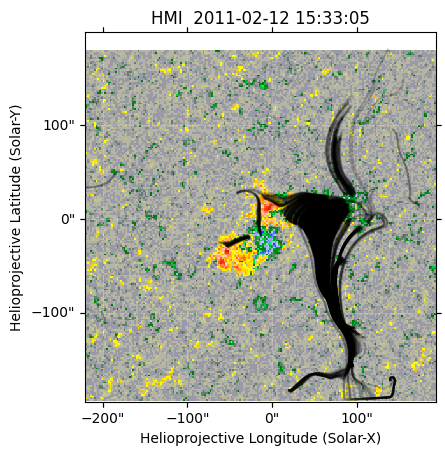

In [82]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_hmi_ar_box)
m_hmi_ar_box.plot(axes=ax,
                  cmap='hmimag',
                  norm=ImageNormalize(vmin=-1500,vmax=1500))
#ax.plot_coord(seed_points, marker='.', color='pink', ls='')
for f in fieldline_coords:
    ax.plot_coord(f, color='k', alpha=.2)

Specify seed points in subregion of boundary map.

In [16]:
blc = SkyCoord(Tx=-100*u.arcsec,
               Ty=-75*u.arcsec,
               frame=extrapolator.boundary_magnetogram.coordinate_frame)
m_hmi_ar_box_zoom = extrapolator.boundary_magnetogram.submap(blc,
                                                             width=250*u.arcsec,
                                                             height=150*u.arcsec)
iy,ix = np.where(m_hmi_ar_box_zoom.data<-1e-3*np.nanmax(m_hmi_ar_box_zoom.data))
seed_points = m_hmi_ar_box_zoom.wcs.array_index_to_world(iy,ix)

/Users/willbarnes/anaconda/envs/greensfield-dev/lib/python3.12/site-packages/astropy/visualization/wcsaxes/patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


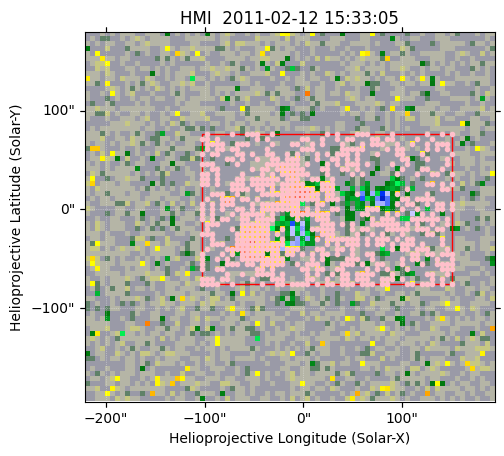

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection=extrapolator.boundary_magnetogram)
extrapolator.boundary_magnetogram.plot(axes=ax,cmap='hmimag', norm=ImageNormalize(vmin=-1500,vmax=1500))
ax.plot_coord(seed_points, marker='.', color='pink', ls='')
extrapolator.boundary_magnetogram.draw_quadrangle(
    m_hmi_ar_box_zoom.bottom_left_coord,
    top_right=m_hmi_ar_box_zoom.top_right_coord,
    axes=ax, color='r')

Trace fieldlines through volume

In [18]:
fieldlines = extrapolator.trace(ds, seeds=seed_points)

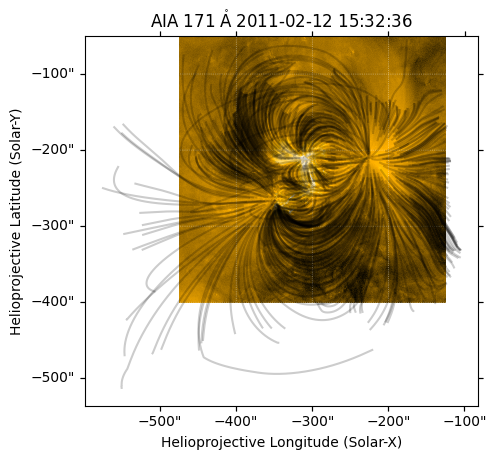

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax)
#ax.plot_coord(seed_points, marker='.', color='pink', ls='')
for f in fieldlines:
    ax.plot_coord(f, color='k', alpha=.2)

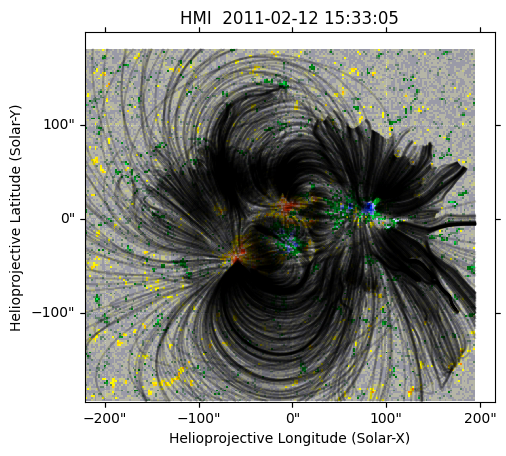

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_hmi_ar_box)
m_hmi_ar_box.plot(axes=ax,
                  cmap='hmimag',
                  norm=ImageNormalize(vmin=-1500,vmax=1500))
#ax.plot_coord(seed_points, marker='.', color='pink', ls='')
for f in fieldlines:
    ax.plot_coord(f, color='k', alpha=.2)

## Fieldline Filtering

In [101]:
def get_length(l):
    return l[1:].separation_3d(l[:-1]).sum()


def is_closed(l, tol=0.005*u.Rsun):
    return np.fabs(np.diff(l.spherical.distance[[0,-1]]) ) < tol


In [47]:
length_bounds = [20,500] * u.Mm

In [42]:
fieldlines_filtered = []
for f in fieldlines:
    if not is_closed(f):
        continue
    if length_bounds[0] <= get_length(f) <= length_bounds[1]:
        fieldlines_filtered.append(f)

In [20]:
np.atleast_1d([20,30]) * np.ones((20,))

ValueError: operands could not be broadcast together with shapes (2,) (20,) 